# Data block API foundations

In [87]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
import sys, os, shutil
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
colabase = Path('/content/drive/My Drive/Colab Notebooks/')
course = Path('/content/drive/My Drive/course-v3/')
dlff = Path('/content/drive/My Drive/deeplearning-ff/')
#sys.path.append(str(dlff)) # cd {dlff}
os.chdir(dlff)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive


In [0]:
#export
from exports.lg_07a import *

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=600)

In [90]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'

## Image ItemList

Previously we were reading in to RAM the whole MNIST dataset at once, loading it as a pickle file. We can't do that for datasets larger than our RAM capacity, so instead we leave the images on disk and just grab the ones we need for each mini-batch as we use them.

Let's use the [imagenette dataset](https://github.com/fastai/imagenette/blob/master/README.md) and build the data blocks we need along the way.

### Get images

In [91]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/root/.fastai/data/imagenette-160')

To be able to look at what's inside a directory from a notebook, we add the `.ls` method to `Path` with a monkey-patch.

In [0]:
#export
import PIL, os, mimetypes
Path.ls = lambda x: list(x.iterdir())  #quickly add shortcut method to Path class

In [93]:
path.ls()

[PosixPath('/root/.fastai/data/imagenette-160/val'),
 PosixPath('/root/.fastai/data/imagenette-160/train')]

In [94]:
(path/'val').ls()

[PosixPath('/root/.fastai/data/imagenette-160/val/n03000684'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03028079'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03445777'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03394916'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03888257'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n02102040'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n02979186'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03417042'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03425413'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764')]

Let's have a look inside a class folder (the first class is tench):

In [0]:
path_tench = path/'val'/'n01440764'

In [96]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00026064.JPEG')

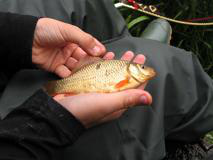

In [97]:
img = PIL.Image.open(img_fn)
img

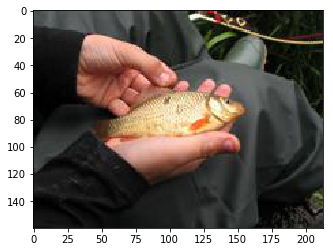

In [98]:
plt.imshow(img)

In [0]:
import numpy
imga = numpy.array(img)

In [100]:
imga.shape

(160, 213, 3)

In [101]:
imga[:10,:10,0] # contains bytes: dtype=uint8 0~255

array([[90, 85, 78, 72, ..., 74, 77, 86, 87],
       [82, 79, 75, 72, ..., 79, 82, 84, 85],
       [77, 76, 74, 73, ..., 80, 82, 80, 82],
       [81, 80, 79, 78, ..., 77, 77, 79, 82],
       ...,
       [75, 76, 76, 77, ..., 78, 78, 79, 83],
       [78, 78, 78, 78, ..., 78, 78, 81, 85],
       [77, 76, 74, 73, ..., 78, 79, 85, 90],
       [77, 76, 74, 72, ..., 74, 75, 89, 90]], dtype=uint8)

Just in case there are other files in the directory (models, texts...) we want to keep only the images. Let's not write it out by hand, but instead use what's already on our computer (the MIME types database).

In [0]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/')) #image extensions

In [103]:
' '.join(image_extensions)

'.pbm .bmp .jp2 .rgb .nef .pnm .ief .pcx .jpe .crw .tif .svg .jpg2 .ico .ras .cdr .ppm .cdt .cr2 .jpg .gif .xpm .svgz .djvu .psd .jpf .xbm .pat .djv .art .orf .jpeg .wbmp .xwd .pgm .erf .tiff .jpm .jpx .cpt .jng .png'

In [0]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))
# fastest way to check if sth is in list is to turn into set

In [0]:
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa',1]), {'aa',1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

Now let's walk through the directories and grab all the images. The first private function grabs all the images inside a given directory and the second one walks (potentially recursively) through all the folder in `path`.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=1325)

In [0]:
#export
def _get_files(p, fs, extensions=None):
    """Get files with given extensions"""
    p = Path(p) # if not Path turn into Path
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [107]:
t = [o.name for o in os.scandir(path_tench)]; # print(t[:3])
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/root/.fastai/data/imagenette-160/ILSVRC2012_val_00026064.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/ILSVRC2012_val_00040833.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/ILSVRC2012_val_00037375.JPEG')]

In [0]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    """Get files from a path, with certain extensions, recursively/not, 
    optionnaly only include certain names."""
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [109]:
get_files(path_tench, image_extensions)[:3]

[PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00026064.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00040833.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00037375.JPEG')]

We need the recurse argument when we start from `path` since the pictures are two level below in directories.

In [110]:
get_files(path, image_extensions, recurse=True)[:3]

[PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00006669.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00045501.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00017801.JPEG')]

In [111]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

Imagenet is 100 times bigger than imagenette, so we need this to be fast.

In [112]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

10 loops, best of 3: 95.1 ms per loop


## Prepare for modeling

What we need to do:

- Get files
- Split validation set
  - random%, folder name, csv, ...
- Label: 
  - folder name, file name/re, csv, ...
- Transform per image (optional)
- Transform to tensor
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=1728)

### Get files

We use the `ListContainer` class from notebook 06 to store our objects in an `ItemList`. The `get` method will need to be subclassed to explain how to access an element (open an image for instance), then the private `_get` method can allow us to apply any additional transform to it.

`new` will be used in conjunction with `__getitem__` (that works for one index or a list of indices) to create training and validation set from a single stream when we split the data.

In [0]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    """Successively pass x into pipe of functions: f1(f2(f3(f4(...fn(x)))))"""
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    """Superclass to override for various types of files. 
    Give it items, a path, and transfroms to apply """
    
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): #also print path 
      return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        # calls constructor; called by SplitData.split_by_func()
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i # override this. base get
    def _get(self, i): return compose(self.get(i), self.tfms) # pass to transforms
    
    def __getitem__(self, idx): #impl. indexing 
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)

class ImageList(ItemList):
    """Image type ItemList"""
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

Transforms aren't only used for data augmentation. To allow total flexibility, `ImageList` returns the raw PIL image. The first thing is to convert it to 'RGB' (or something else).

Transforms only need to be functions that take an element of the `ItemList` and transform it. If they need state, they can be defined as a class. Also, having them as a class allows to define an `_order` attribute (default 0) that is used to sort the transforms.

In [0]:
#export
class Transform(): _order=0 # base class with _order 0 by default

class MakeRGB(Transform):
    """Class version of transform"""
    def __call__(self, item): return item.convert('RGB') 

def make_rgb(item): 
  """Function version of transform"""
  return item.convert('RGB') #item needs to PIL.Image.open() obj

In [0]:
il = ImageList.from_files(path, tfms=make_rgb)

In [116]:
il # call __repr__ , with Path also printed 

ImageList (13394 items)
[PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00006669.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00045501.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00017801.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00017719.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00035266.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00005506.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00045940.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00031413.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00031549.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00027785.JPEG')...]
Path: /root/.fastai/data/imagenette-160

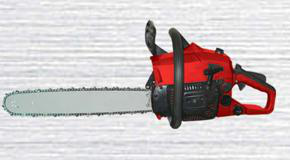

In [117]:
img = il[0]; img  # __getitem__ ultimately gives you PIL.Image.open(fn)

We can also index with a range or a list of integers:

In [118]:
il[:1] #[0]

[<PIL.Image.Image image mode=RGB size=290x160 at 0x7F5CD01D10B8>]

### Split validation set

Here, we need to split the files between those in the folder train and those in the folder val.

In [119]:
fn = il.items[0] #self.items = listify(items) in ListContainer
fn

PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00006669.JPEG')

Since our filenames are `path` object, we can find the directory of the file with `.parent`. We need to go back two folders before since the last folders are the class names.

In [120]:
fn.parent.parent.name

'val'

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=2175)

In [0]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(items, f):
    """Return two lists, depending to masks create for members of items by f,
    f in func that creates mask (ie list of True/False)"""
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    faux = [o for o,m in zip(items,mask) if m==False]
    vrai = [o for o,m in zip(items,mask) if m==True ]
    return faux,vrai

In [0]:
splitter = partial(grandparent_splitter, valid_name='val')

In [123]:
%time train,valid = split_by_func(il, splitter)

CPU times: user 56.1 ms, sys: 1.23 ms, total: 57.4 ms
Wall time: 56.8 ms


In [124]:
len(train),len(valid)
valid[:3]

[PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00006669.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00045501.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03000684/ILSVRC2012_val_00017801.JPEG')]

Now that we can split our data, let's create the class that will contain it. It just needs two `ItemList` to be initialized, and we create a shortcut to all the unknown attributes by trying to grab them in the `train` `ItemList`. 

In [0]:
#export
class SplitData():
    def __init__(self, train, valid): self.train,self.valid = train,valid
        
    def __getattr__(self,k): return getattr(self.train,k)
    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors
    def __setstate__(self,data:Any): self.__dict__.update(data) 
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        # applies ItemList.new() method to each list returned by split_by_func
        # which in turn calls constructor of ItemList; for same tupe, same transforms, same path
        # lists contains [train_il, valid_il]
        return cls(*lists)

    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [126]:
sd = SplitData.split_by_func(il, splitter) #u got two ImageList from original ImageList
sd

SplitData
Train: ImageList (12894 items)
[PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_16026.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_5805.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_11070.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_21209.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_11511.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_26449.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_8115.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_12757.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_36107.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_15691.JPEG')...]
Path: /root/.fastai/data/imagenette-160
Valid: ImageList (500 items)
[PosixPath('/root/.fastai/data/imagene

### Labeling

Labeling has to be done *after* splitting, because it uses *training* set information to apply to the *validation* set, using a *Processor*.

A *Processor* is a transformation that is applied to all the inputs once at initialization, with some *state* computed on the training set that is then applied without modification on the validation set (and maybe the test set or at inference time on a single item). For instance, it could be **processing texts** to **tokenize**, then **numericalize** them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in **tabular data**, where we **fill missing values** with (for instance) the median computed on the training set. That statistic is stored in the inner state of the *Processor* and applied on the validation set.

In our case, we want to **convert label strings to numbers** in a consistent and reproducible way. So we create a list of possible labels in the training set, and then convert our labels to numbers based on this *vocab*.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=2368)

In [0]:
#export
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

First, let's define the processor. We also define a `ProcessedItemList` with an `obj` method that can get the unprocessed items: for instance a processed label will be an index between 0 and the number of classes - 1, the corresponding `obj` will be the name of the class. The first one is needed by the model for the training, but the second one is better for displaying the objects.

In [0]:
#export
class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):
    """Give me items, i'll give you their int/label"""
    def __init__(self): self.vocab=None
    
    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            #vocab not define so we define here
            self.vocab = uniqueify(items)
            # go from object to int with following dict; reverse mapping
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item):  return self.otoi[item] #get int from item
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx] # get item from int

Here we label according to the folders of the images, so simply `fn.parent.name`. We label the training set first with a newly created `CategoryProcessor` so that it computes its inner `vocab` on that set. Then we label the validation set using the same processor, which means it uses the same `vocab`. The end result is another `SplitData` object.

In [0]:
#export
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11 (12?)
class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x,self.y = self.process(x, proc_x),self.process(y, proc_y)
        self.proc_x,self.proc_y = proc_x,proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [0]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [0]:
assert ll.train.proc_y is ll.valid.proc_y

In [132]:
ll.train.y

ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: /root/.fastai/data/imagenette-160

In [133]:
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(2))

(0, 'n03000684', ['n03000684', 'n03000684'])

In [134]:
ll

SplitData
Train: LabeledData
x: ImageList (12894 items)
[PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_16026.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_5805.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_11070.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_21209.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_11511.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_26449.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_8115.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_12757.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_36107.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03000684/n03000684_15691.JPEG')...]
Path: /root/.fastai/data/imagenette-160
y: ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0

### Transform to tensor

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=3044)

In [135]:
ll.train[0] # tuple (x,y) x=img y=label

(<PIL.Image.Image image mode=RGB size=160x227 at 0x7F5CD0165198>, 0)

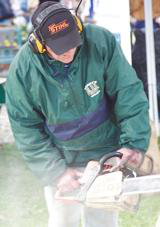

In [136]:
ll.train[0][0] #x

To be able to put all our images in a batch, we need them to have all the same size. We can do this easily in PIL.

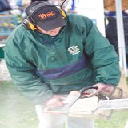

In [137]:
ll.train[0][0].resize((128,128))

The first transform resizes to a given size, then we convert the image to a by tensor before converting it to float and dividing by 255. We will investigate data augmentation transforms at length in notebook 10.

In [0]:
#export
class ResizeFixed(Transform):
    _order=10 #Happens after RGB transf etc
    def __init__(self,size):
        if isinstance(size,int): size=(size,size) # make it tuple if not
        self.size = size
        
    def __call__(self, item): 
      return item.resize(self.size, PIL.Image.BILINEAR) # type of resize

def to_byte_tensor(item):
    """Go from PIL to byte-Tensor, as in Torchvision"""
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1) # PIL has channel last, Pytorch has it fist
to_byte_tensor._order=20 # needs to happen after resizing, attach state to function

def to_float_tensor(item): return item.float().div_(255.) #div in place 
to_float_tensor._order=30  # after tobyte_tensor

In [0]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor] 
# _order determines order in which apllied, not position in this list

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor()) #no need to proc x, we jst need labeling 

Here is a little convenience function to show an image from the corresponding tensor.

In [0]:
#export
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0)) # need to put chanel last again

In [141]:
x,y = ll.train[0]
x.shape,y

(torch.Size([3, 128, 128]), 0)

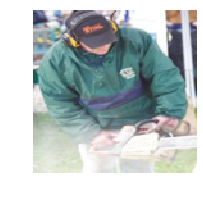

In [142]:
show_image(x)

## Modeling

### DataBunch

Now we are ready to put our datasets together in a `DataBunch`.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=3226)

In [0]:
bs=64

In [0]:
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=4) #Pytorch dataloaders see lg_03_trainloop.py

In [0]:
x,y = next(iter(train_dl)) #one batch

In [146]:
x.shape

torch.Size([64, 3, 128, 128])

We can still see the images in a batch and get the corresponding classes.

'n03028079'

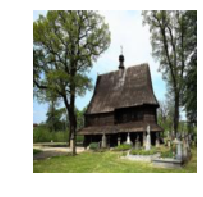

In [147]:
show_image(x[0])
ll.train.proc_y.vocab[y[0]]

In [148]:
y

tensor([1, 8, 9, 8, 1, 7, 8, 1, 6, 6, 2, 1, 3, 4, 8, 3, 1, 8, 5, 9, 6, 7, 1, 4,
        4, 1, 8, 4, 5, 7, 4, 4, 3, 8, 5, 4, 9, 0, 0, 2, 5, 9, 0, 6, 9, 4, 8, 3,
        8, 5, 2, 6, 1, 4, 6, 6, 1, 9, 1, 4, 2, 0, 3, 4])

We change a little bit our `DataBunch` to add a few attributes: `c_in` (for channel in) and `c_out` (for channel out) instead of just `c`. This will help when we need to build our model.

In [0]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        """Contains dataloaders and datasets
        c_in and c_out to be used in model creation. """
        self.train_dl,self.valid_dl,self.c_in,self.c_out = train_dl,valid_dl,c_in,c_out

    @property
    def train_ds(self): return self.train_dl.dataset #direct access to ds from db

    @property
    def valid_ds(self): return self.valid_dl.dataset

Then we define a function that goes directly from the `SplitData` to a `DataBunch`.

In [0]:
#export
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    """function that goes directly from the SplitData to a DataBunch"""
    dls = get_dls(sd.train, sd.valid, bs, **kwargs) #get dataloaders
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify # add (instance) method to Class SplitData

This gives us the full summary on how to grab our data and put it in a `DataBunch`:

In [0]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

### Model

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=3360)

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback]

We will normalize with the statistics from a batch.

In [153]:
m,s = x.mean((0,2,3)).cuda(),x.std((0,2,3)).cuda() # take avg over dims other than channel
m,s

(tensor([0.4570, 0.4391, 0.4030], device='cuda:0'),
 tensor([0.2701, 0.2746, 0.2961], device='cuda:0'))

In [0]:
#export
def normalize_chan(x, mean, std):
    """normalize by channel. Add 2 dimensions to make sure broadcasting works. 
    Batch dimension will be padded in autom. in the front"""
    return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [0]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

In [0]:
nfs = [64,64,128,256]

We build our model using [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187), in particular: we don't use a big conv 7x7 at first but three 3x3 convs, and don't go directly from 3 channels to 64 but progressively add those.

In [0]:
#export
import math
def prev_pow_2(x): 
    """What power of 2 is just before x """
    return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    """Reutrns list of conv layers (incl BN, and Relu)"""
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in # model knows #channel/inputs from the databach
    l2 = prev_pow_2(l1*3*3) # secound layer needs to be smaller pow of 2 than 27
    #that way, that layer is crunching info, not 'losing' any 
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
               nn.Linear(nfs[-1], data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    """Returns nn.Sequential based on layer list from get_cnn_layers"""
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [0]:
sched = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.1,0.3,0.05))

In [0]:
learn,run = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)
])

Let's have a look at our model using Hooks. We print the layers and the shapes of their outputs.

In [0]:
#export
def model_summary(run, learn, data, find_all=False):
    """Defines hook and prints model arch by running one batch forward pass"""
    xb,yb = get_batch(data.valid_dl, run) #get one batch
    device = next(learn.model.parameters()).device#Model may not be on the GPU yet
    xb,yb = xb.to(device),yb.to(device)
    #recusive or not?--> find_all
    mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
    f = lambda hook,mod,inp,out: print(f"{mod}\n{out.shape}\n") 
    #quick hook on the fly, (hook + 3param) input;#hook will print module and out-shape
    with Hooks(mods, f) as hooks: learn.model(xb) #one forward pass on batch to activate/populate hooks

In [160]:
model_summary(run, learn, data)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 32, 64, 64])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 16, 16])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(

And we can train the model:

In [161]:
%time run.fit(5, learn)

train: [1.7935279975182254, tensor(0.3767, device='cuda:0')]
valid: [1.449177490234375, tensor(0.5340, device='cuda:0')]
train: [1.3585949012137428, tensor(0.5472, device='cuda:0')]
valid: [1.368712646484375, tensor(0.5700, device='cuda:0')]
train: [1.0142023421746549, tensor(0.6708, device='cuda:0')]
valid: [1.0961981201171875, tensor(0.6340, device='cuda:0')]
train: [0.7584034058961533, tensor(0.7551, device='cuda:0')]
valid: [0.9215225830078125, tensor(0.7220, device='cuda:0')]
train: [0.5483359053871956, tensor(0.8312, device='cuda:0')]
valid: [0.8283590087890625, tensor(0.7340, device='cuda:0')]
CPU times: user 16.4 s, sys: 8.47 s, total: 24.8 s
Wall time: 1min 47s


The [leaderboard](https://github.com/fastai/imagenette/blob/master/README.md) as this notebook is written has ~85% accuracy for 5 epochs at 128px size, so we're definitely on the right track!

## Export

In [162]:
!pip install fire
!python notebook2script.py 08_data_block.ipynb

     |████████████████████████████████| 81kB 3.1MB/s 
  Created wheel for fire: filename=fire-0.2.1-py2.py3-none-any.whl size=103527 sha256=10b12dd875e68c0e4be84038dd7259812d44c9c3df43710356ffab537f941455
  Stored in directory: /root/.cache/pip/wheels/31/9c/c0/07b6dc7faf1844bb4688f46b569efe6cafaa2179c95db821da
Successfully built fire
Converted 08_data_block.ipynb to exports/lg_08.py
